In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
import pymc3 as pm

In [4]:
rng = np.random.RandomState(1994)

## Reading Data

In [2]:
clients_df = pd.read_csv('b2b_dataset.csv')

In [53]:
clients_df.sample(6)

,id,price,purchase,country
179,179,7.0,0,Germany
122,122,3.5,1,France
218,218,7.5,0,France
176,176,7.0,0,Germany
48,48,4.5,1,Italy
29,29,7.5,0,Germany


# Data Exploration

In [3]:
clients_df.columns

Index(['id', 'price', 'purchase', 'country'], dtype='object')

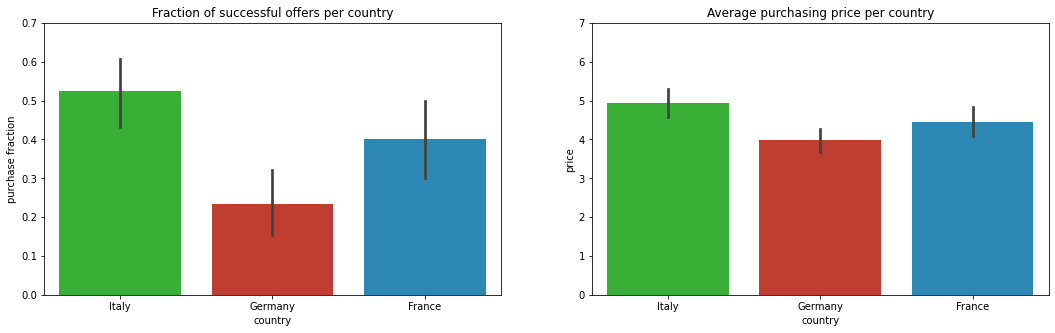

In [41]:
colors = ['#26C421', '#D8291A', '#168FC8']
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (18, 5))
sns.barplot(x='country', y='purchase', ci=95, data=clients_df, palette = colors, ax = ax1);
sns.barplot(x='country', y='price', ci=95, palette = colors, data=clients_df.loc[clients_df['purchase'] == 1], ax = ax2);
ax1.set_title('Fraction of successful offers per country')
ax2.set_title('Average purchasing price per country')
ax1.set_ylabel('purchase fraction')
ax1.set_ylim(0,0.7)
ax2.set_ylim(0,7);
plt.savefig('imgs/figure1.png')

# Analysis

### train-test split

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X = clients_df[['price', 'country']]
y = clients_df['purchase']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### PyMC3 and a Bayesian Hierarchical Model
### Pooled Bayesian Model

In [9]:
with pm.Model() as pooled_model:

    # define b0 and b1 priors
    b0 = pm.Normal('b0', mu=0, sd=100)
    b1 = pm.Lognormal('b1', mu=0, sd=100)

    # compute the purchase probability for each case
    logit_p = b0 - b1 * X_train['price'].to_list()
    likelihood = pm.Bernoulli('likelihood', logit_p=logit_p, observed=list(y_train))
    
    posterior = pm.sample(draws = 6000, tune = 3000)

/Users/vadim/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b1, b0]


Sampling 4 chains for 3_000 tune and 6_000 draw iterations (12_000 + 24_000 draws total) took 32 seconds.
The acceptance probability does not match the target. It is 0.8975004842311144, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


/Users/vadim/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


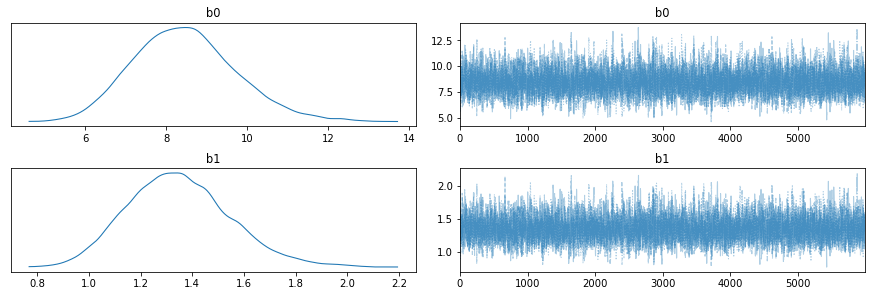

In [10]:
pm.traceplot(posterior, combined = True);

In [11]:
df = pm.trace_to_dataframe(posterior)
df.head()

,b0,b1
0,8.678690,1.355506
1,8.578479,1.367584
2,7.799236,1.231353
3,7.842660,1.238527
4,7.842660,1.238527


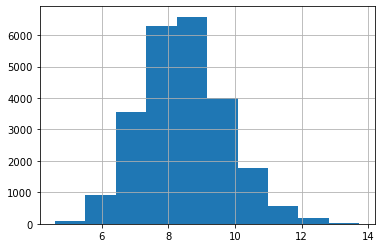

In [12]:
df['b0'].hist();

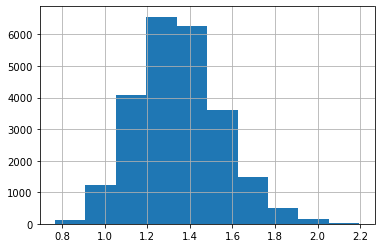

In [13]:
df['b1'].hist();

In [14]:
# infering probabilities for the test set and making predictions
logit_value = df['b0'].mean() - df['b1'].mean()* X_test['price']
predicted_probability = np.exp(logit_value) / (1 + np.exp(logit_value))

In [16]:
from sklearn.metrics import accuracy_score, classification_report

In [17]:
# calculating accuracy for the pooled model
print(accuracy_score(predicted_probability > 0.5, y_test).round(3))
print(classification_report(predicted_probability > 0.5, y_test))

0.854
              precision    recall  f1-score   support

       False       0.87      0.90      0.89        60
        True       0.82      0.78      0.80        36

    accuracy                           0.85        96
   macro avg       0.85      0.84      0.84        96
weighted avg       0.85      0.85      0.85        96



## Hierarchal Bayesian model 

In [18]:
n_countries = X_train['country'].nunique()
n_countries

3

In [19]:
country_to_index = {'Italy' : 0, 'Germany' : 1, 'France' : 2}
ids_train = X_train['country'].apply(lambda x: country_to_index[x])
ids_test = X_test['country'].apply(lambda x: country_to_index[x])

In [24]:
with pm.Model() as hier_model:
    
    # priors for common distribution's mu and sigma
    mu_b0 = pm.Normal('mu_b0', mu=0, sd=100)
    mu_b1 = pm.Normal('mu_b1', mu=0, sd=100)

    sigma_b0 = pm.InverseGamma('sigma_b0', alpha=3, beta=20)
    sigma_b1 = pm.InverseGamma('sigma_b1', alpha=3, beta=20)

    # country-specific draws 
    b0 = pm.Normal('b0', mu=mu_b0, sd=sigma_b0, shape=n_countries)
    b1 = pm.Lognormal('b1', mu=mu_b1, sd=sigma_b1, shape=n_countries)

    # compute the purchase probability for each case
    logit_p = b0[ids_train] - b1[ids_train] * list(X_train['price'])
    likelihood = pm.Bernoulli('likelihood', logit_p=logit_p, observed=list(y_train))
    
    posterior = pm.sample(draws = 10000, tune = 5000, target_accept = 0.9)

/Users/vadim/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b1, b0, sigma_b1, sigma_b0, mu_b1, mu_b0]


Sampling 4 chains for 5_000 tune and 10_000 draw iterations (20_000 + 40_000 draws total) took 138 seconds.


/Users/vadim/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


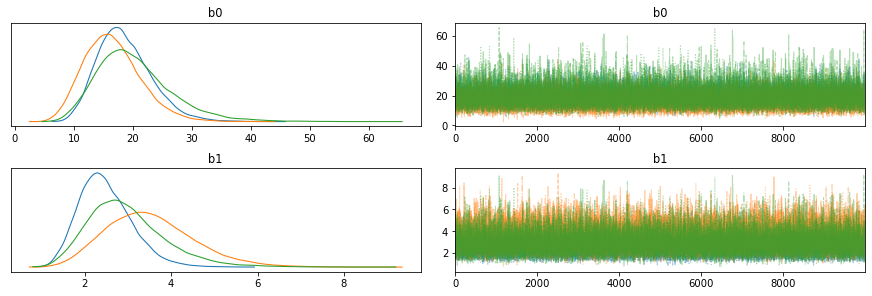

In [26]:
pm.traceplot(posterior, combined = True, var_names = ['b0', 'b1']);

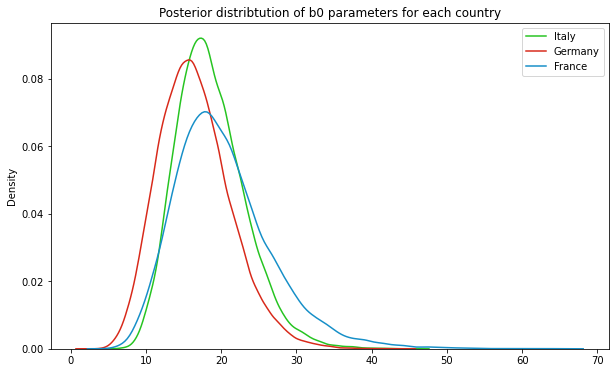

In [42]:
# making a more customizable plot

fig, ax = plt.subplots(figsize = (10,6))
sns.kdeplot(posterior.get_values('b0')[:, 0], ax = ax, label = 'Italy', color = '#26C421')
sns.kdeplot(posterior.get_values('b0')[:, 1], ax = ax, label = 'Germany', color = '#D8291A')
sns.kdeplot(posterior.get_values('b0')[:, 2], ax = ax, label = 'France', color = '#168FC8')
plt.title('Posterior distribtution of b0 parameters for each country')
plt.legend();
plt.savefig('imgs/figure-hier_b0.png');

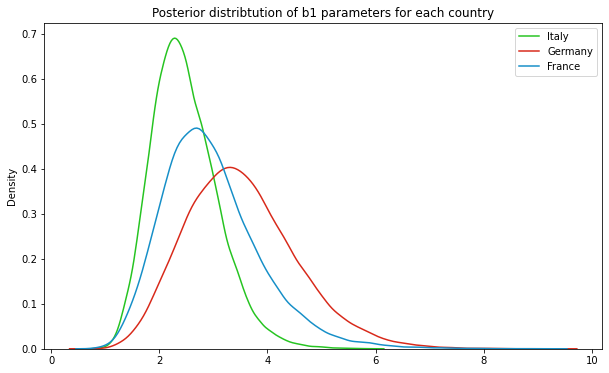

In [43]:
fig, ax = plt.subplots(figsize = (10,6))
sns.kdeplot(posterior.get_values('b1')[:, 0], ax = ax, label = 'Italy', color = '#26C421')
sns.kdeplot(posterior.get_values('b1')[:, 1], ax = ax, label = 'Germany', color = '#D8291A')
sns.kdeplot(posterior.get_values('b1')[:, 2], ax = ax, label = 'France', color = '#168FC8')
plt.title('Posterior distribtution of b1 parameters for each country')
plt.legend();
plt.savefig('imgs/figure-hier_b1.png');

In [32]:
def make_hier_prediction(prices: np.array, country_index: int, posterior_values: np.array = posterior, get_whole_distribution: bool = False) -> float:
    
    """
    Given an array of prices (or a single)
    """
    
    country_b0 = posterior_values.get_values('b0')[:, country_index]
    country_b1 = posterior_values.get_values('b1')[:, country_index]
    
    if not get_whole_distribution:
        country_b0 = country_b0.mean()
        country_b1 = country_b1.mean()
    
    
    logit_value = country_b0 - country_b1 * prices
    predicted_probability = np.exp(logit_value) / (1 + np.exp(logit_value))
    
    return predicted_probability

In [33]:
# getting test predictions

y_test_predict = []
for i in range(len(X_test)):
    country_idx = country_to_index[X_test['country'].iloc[i]]
    predicted_prob = make_hier_prediction(X_test['price'].iloc[i], country_idx)
    y_test_predict.append(predicted_prob >= 0.5)

In [34]:
# checking accuracy
accuracy_score(y_test_predict, y_test).round(3)

0.938

### How likely are customers in each country to buy for a price of 7?

Note: Germany gets a discount of 2

In [36]:
italy_prob7 = make_hier_prediction(np.array([7]), 0, get_whole_distribution = True)
germany_prob5 = make_hier_prediction(np.array([5]), 1, get_whole_distribution = True)
france_prob7 = make_hier_prediction(np.array([7]), 2, get_whole_distribution = True)

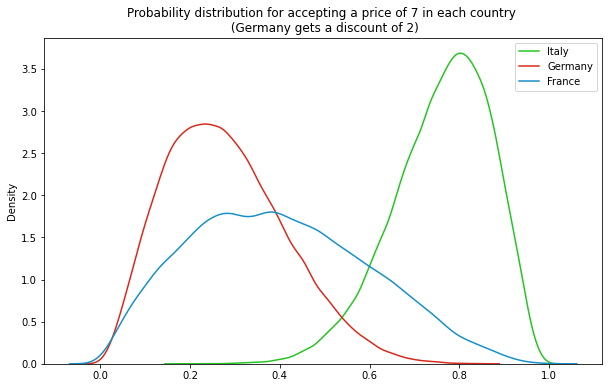

In [44]:
fig, ax = plt.subplots(figsize = (10,6))
sns.kdeplot(italy_prob7, ax=ax, label = 'Italy', color = '#26C421')
sns.kdeplot(germany_prob5, ax=ax, label = 'Germany', color = '#D8291A')
sns.kdeplot(france_prob7, ax=ax, label = 'France', color = '#168FC8')
plt.title('Probability distribution for accepting a price of 7 in each country \n (Germany gets a discount of 2)')
plt.legend();
plt.savefig('imgs/figure-hier_case.png');